# Artificial Intelligence II - Homework 3
---
###Δημήτριος Σιταράς | 1115201800178
---

## Libraries n' Functions 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import random
import sys
from torchtext import data
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

!pip install tweet-preprocessor

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [2]:
def lossCurve(trainLosses,valLosses):
  plt.plot(trainLosses, color="r")
  plt.plot(valLosses, color="g")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train Loss','Validation Loss'])
  plt.show()

In [3]:
def rocCurve(validation_prediction,yValidation):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes=3
  validationPrediction=validation_prediction.detach().numpy()
  yLabelsBin = label_binarize(yValidation, classes=[0,1,2])
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(yLabelsBin[:,i], validationPrediction[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  lw = 2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

In [4]:
import string
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import preprocessor as p
nltk.download('wordnet')

def cleaning(text):
    # used to clean urls, mentions (with @), emojis, punctuation marks and all the other symbols that exist
    p.set_options(p.OPT.URL,p.OPT.MENTION)
    text = p.clean(text)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text).split())

def stemming(text):
    # used to reduce the inflection in words to their root 
    # SnowBallStemmer used for this job
    SnowStemmer = SnowballStemmer("english")
    stemmedΤokens = [SnowStemmer.stem(token) for token in text.split()]
    return ' '.join(stemmedΤokens)

def lemmatization(text):
    # used to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stringList = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
    return ' '.join([str(element) for element in stringList])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [6]:
!unzip /content/glove.twitter.27B.zip

## Data Loading and Preprocessing

In [7]:
Location = r'vaccine_train_set.csv'
trainDf=pd.read_csv(Location)
Location = r'vaccine_validation_set.csv'  # replace this one with the path of test set
validationDf=pd.read_csv(Location)

In [8]:
# preprocessing
trainDf['tweet'] = trainDf['tweet'].apply(cleaning)
trainDf['tweet'] = trainDf['tweet'].apply(lemmatization)

validationDf['tweet'] = validationDf['tweet'].apply(cleaning)
validationDf['tweet'] = validationDf['tweet'].apply(lemmatization)


In [9]:
# remove the first column from the train and the validation datasets, it has the numbering of columns
trainDf=trainDf.drop(trainDf.columns[0], axis=1) 
validationDf=validationDf.drop(validationDf.columns[0], axis=1)

In [10]:
# then save at new csvs these two datasets, without the first column
trainDf.to_csv("/content/vaccine_train_set_new.csv", index=False)
validationDf.to_csv("/content/vaccine_validation_set_new.csv", index=False)

## Vectorization: build vocabulary using GloVe

Χρησιμοποιώ το αρχείο glove.twitter.27B.100d.txt, στο οποίο υπάρχουν λέξεις που αναπαριστόνται απο διανύσματα 100 διαστάσεων. Κάθε γραμμή του αρχείου περιέχει ως πρώτο στοιχείο μια λέξη ακολουθούμενη απο 100 πραγματικούς αριθμούς.
Με την βοήθεια λοιπόν και του torchtext, κατασκευάζω με βάση τις λέξεις που περιέχονται παράλληλα στο παραπάνω αρχείο και στα sets, ένα λεξικό, όπου ουσιαστικά περίεχει για κάθε λέξη με τα αντίστοιχα embeddings της μέσα σε tensors.

In [11]:
from torchtext.legacy import data
import spacy

TEXT = data.Field(dtype=torch.long,sequential=True, tokenize="spacy", batch_first=True)
LABEL = data.LabelField(dtype=torch.long, batch_first=True, sequential=False)

In [12]:
datafields=[('Tweet', TEXT),('Label', LABEL)]
tweetsTrain, tweetsVal = data.TabularDataset.splits( 
    path="", 
    train= '/content/vaccine_train_set_new.csv', 
    validation= '/content/vaccine_validation_set_new.csv', 
    format="csv", 
    skip_header=True, 
    fields=datafields)


In [13]:
from torchtext.vocab import Vectors, GloVe
vectors = Vectors(name='glove.twitter.27B.100d.txt')
TEXT.build_vocab(tweetsTrain, tweetsVal, vectors=vectors, max_size=10000, min_freq=6)
LABEL.build_vocab(tweetsTrain)

In [14]:
print(f"Tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Tokens in TEXT vocabulary: 4447
Tokens in LABEL vocabulary: 3


In [15]:
np.shape(TEXT.vocab.vectors)

torch.Size([4447, 100])

## Creation of Iterators 

In [16]:
batch_size = 100
# BucketIterator groups sequence of similar lengths text in a batch together to minimize padding,
# in order to create the corresponding iterators from train and validation sets
trainItr, valItr = data.BucketIterator.splits(
    (tweetsTrain, tweetsVal),
    batch_size=batch_size,
    sort_key=lambda x:len(x.Tweet), # how to group the sequences
    shuffle=True,
    sort_within_batch=True,
    sort=False)

## Bidirectional stacked RNN with LSTM/GRU

In [17]:
class Attention(nn.Module):
    # http://web.stanford.edu/class/cs224n/slides/cs224n-2021-lecture07-nmt.pdf -> page 75
    def __init__(self,timestep,hidden_dim):
        super(Attention, self).__init__()
        self.weight1 = nn.Parameter(torch.Tensor(hidden_dim*2, hidden_dim*2))
        self.weight2 = nn.Parameter(torch.Tensor(timestep, hidden_dim*2))
        # initialize the weights using normal distribution with mean = 0.0 and std = 0.05
        self.weight1.data.normal_(0.0, 0.05)
        self.weight2.data.normal_(0.0, 0.05)
        
    def forward(self, cell_out):
        # cell out form is : (batch_size, seq_len, hidden_size)
        out = torch.matmul(self.weight1, cell_out.permute(0, 2, 1)) # matrix multiplication (permute rearranges the tensor "cell_out" to the desired ordering (batch_size, seq_len, hidden_size) -> (batch_size, hidden_size, seq_len ) in order to do the matrix multiplication)
        out = torch.tanh(out)
        out = torch.matmul(self.weight2, out) # matrix multiplication, get the attentions scores 
        out = nn.functional.softmax(out, dim=2) # softmax to get the attention distribution
        out = torch.bmm(out, cell_out) # concatenate the attention output with cell's output
        
        return out


class RNN(nn.Module):

    cells = {
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
        }   

    def __init__(self, cell_type, attention_flag, embeddings, embedding_dim, output_size, hidden_dim, n_layers, dropout):
        super(RNN, self).__init__()

        self.cell_type = cell_type
        self.attention_flag=attention_flag
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(embeddings,freeze=True) # load pre-trained vecs, "freeze=True" make embedding non-trainable
        self.cell = RNN.cells[cell_type](embedding_dim, hidden_dim, n_layers,bidirectional=True,batch_first=True,dropout=dropout) # batch_first=True, so now the batch size is at the first dimension (batch_size, seq_len, hidden_size)
        self.linear = nn.Linear(hidden_dim*2, output_size)
        self.dropout = torch.nn.Dropout(dropout)
        if (attention_flag):
          self.attention_layer = Attention(100,hidden_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.embedding(x)
        x = self.dropout(x)
        cell_out, hidden = self.cell(x, hidden)
        
        if (self.attention_flag):
          cell_out = self.attention_layer(cell_out)
          
        out = self.linear(cell_out)

        out = out[:, -1, :]
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # init hidden states with zeros
        weight = next(self.parameters()).data
        if (self.cell_type == 'LSTM'):
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())
        elif (self.cell_type == 'GRU'):
          hidden = weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_()
        return hidden


## Setup

In [18]:
# Define Hyperparameters
output_size = 3
embedding_dim = TEXT.vocab.vectors.shape[1]
hidden_dim = 40
n_layers = 2
dropout = 0.1
cell_type ='LSTM'
attention_flag = False

# Initialize model, loss function, optimizer
model = RNN(cell_type,attention_flag,TEXT.vocab.vectors, embedding_dim, output_size, hidden_dim, n_layers, dropout)
  
lr=2e-3
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [19]:
model

RNN(
  (embedding): Embedding(4447, 100)
  (cell): LSTM(100, 40, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=80, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## Train and evalute the model

In [20]:
epochs = 11
trainLosses=[]
valLosses=[]

for i in range(epochs):
    train_h = model.init_hidden(batch_size)
    model.train()
    batchLosses = []
    for batch in trainItr:

        if model.cell_type == 'LSTM':
          train_h = tuple([x.data for x in train_h])
        elif model.cell_type == 'GRU':
          train_h = train_h.detach()
        
        if batch.Tweet.shape[0] == batch_size:

          optimizer.zero_grad() # Delete previously stored gradients

          output, train_h = model(batch.Tweet, train_h)
          trainLoss = loss_func(output, batch.Label)
          batchLosses.append(trainLoss.item())

          trainLoss.backward()  # Perform backpropagation starting from the loss calculated in this epoch
          nn.utils.clip_grad_norm_(model.parameters(),5) # Clip gradients to avoid vanishing gradients
          optimizer.step() # Update model's weights based on the gradients calculated during backprop

    trainCurrentLoss = sum(batchLosses)/len(trainItr)
    trainLosses.append(trainCurrentLoss) 

    with torch.no_grad(): # evaluation, don't calculate gradients
      model.eval()
      val_h = model.init_hidden(batch_size)
      batchLosses = []
      for batch in valItr:

        if model.cell_type == 'LSTM':
          val_h = tuple([x.data for x in val_h])
        elif model.cell_type == 'GRU':
          val_h = val_h.detach()
        
        if batch.Tweet.shape[0] == batch_size:

          output, val_h = model(batch.Tweet, val_h)
          valLoss = loss_func(output, batch.Label)
          batchLosses.append(valLoss.item())

    valCurrentLoss = sum(batchLosses)/len(valItr)
    valLosses.append(valCurrentLoss)
    print("Epoch: {}/{}...".format(i+1, epochs), "Train Loss: {:.6f} |".format(trainCurrentLoss), "Val Loss: {:.6f}".format(valCurrentLoss))


Epoch: 1/11... Train Loss: 0.929288 | Val Loss: 0.819168
Epoch: 2/11... Train Loss: 0.843059 | Val Loss: 0.794607
Epoch: 3/11... Train Loss: 0.817416 | Val Loss: 0.779161
Epoch: 4/11... Train Loss: 0.802716 | Val Loss: 0.772819
Epoch: 5/11... Train Loss: 0.791114 | Val Loss: 0.755729
Epoch: 6/11... Train Loss: 0.776866 | Val Loss: 0.745168
Epoch: 7/11... Train Loss: 0.762410 | Val Loss: 0.743788
Epoch: 8/11... Train Loss: 0.753456 | Val Loss: 0.737952
Epoch: 9/11... Train Loss: 0.737408 | Val Loss: 0.736151
Epoch: 10/11... Train Loss: 0.725508 | Val Loss: 0.726354
Epoch: 11/11... Train Loss: 0.722196 | Val Loss: 0.739753


## Accuracy, Precision, Recall, F1-Score, Support, Loss and Roc Curves 

In [21]:
from sklearn.metrics import classification_report

with torch.no_grad(): # evaluation, don't calculate gradients
  correctPreds = 0
  sum = 0
  model.eval()   
  labels = []   
  validation_predictions = []
  validation_predictionsROC=torch.tensor([])
  for batch in valItr:
    validation_prediction,_ = model(batch.Tweet,hidden=None)
    validation_predictionsROC=torch.concat([validation_predictionsROC, validation_prediction], 0)
    _, predictedLabel = torch.max(validation_prediction.data,1)    
    correctPreds += (predictedLabel==batch.Label).sum().item()    
    sum += len(batch.Label)
    validation_predictions += list(predictedLabel)
    labels += list(batch.Label.detach().numpy()) 
    
acc = correctPreds / sum
print('Accuracy: {}'.format(acc*100))
print(classification_report(validation_predictions,labels))


Accuracy: 65.55652936021035
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1212
           1       0.66      0.64      0.65       947
           2       0.22      0.54      0.32       123

    accuracy                           0.66      2282
   macro avg       0.55      0.62      0.56      2282
weighted avg       0.70      0.66      0.67      2282



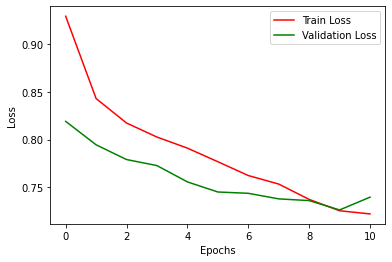

In [22]:
lossCurve(trainLosses,valLosses)

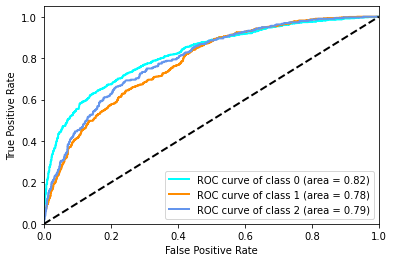

In [23]:
rocCurve(validation_predictionsROC,labels)